In [2]:
!date
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
%matplotlib inline
sns.set_context('paper')
sns.set_style('darkgrid')

Mon Aug 17 14:54:44 CEST 2015


# Mixture Model in PyMC3

Original NB by Abe Flaxman, modified by Thomas Wiecki


In [3]:
import pymc3 as pm, theano.tensor as tt

/home/wiecki/miniconda3/lib/python3.4/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
/home/wiecki/miniconda3/lib/python3.4/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")


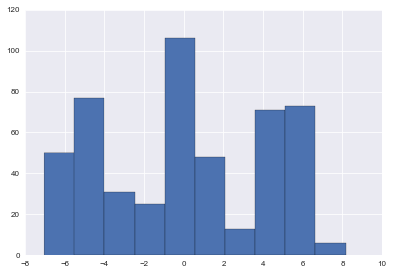

In [6]:
# simulate data from a known mixture distribution
np.random.seed(12345) # set random seed for reproducibility

k = 3
ndata = 500
spread = 5
centers = np.array([-spread, 0, spread])

# simulate data from mixture distribution
v = np.random.randint(0, k, ndata)
data = centers[v] + np.random.randn(ndata)

plt.hist(data);

In [8]:
# setup model
model = pm.Model()
with model:
    # cluster sizes
    a = pm.constant(np.array([1., 1., 1.]))
    p = pm.Dirichlet('p', a=a, shape=k)
    # ensure all clusters have some points
    p_min_potential = pm.Potential('p_min_potential', tt.switch(tt.min(p) < .1, -np.inf, 0))


    # cluster centers
    means = pm.Normal('means', mu=[0, 0, 0], sd=15, shape=k)
    # break symmetry
    order_means_potential = pm.Potential('order_means_potential',
                                         tt.switch(means[1]-means[0] < 0, -np.inf, 0)
                                         + tt.switch(means[2]-means[1] < 0, -np.inf, 0))
    
    # measurement error
    sd = pm.Uniform('sd', lower=0, upper=20)

    # latent cluster of each observation
    category = pm.Categorical('category',
                              p=p,
                              shape=ndata)

    # likelihood for each observed value
    points = pm.Normal('obs',
                       mu=means[category],
                       sd=sd,
                       observed=data)

In [9]:
# fit model
with model:
    step1 = pm.Metropolis(vars=[p, sd, means])
    step2 = pm.ElemwiseCategoricalStep(var=category, values=[0, 1, 2])
    tr = pm.sample(10000, step=[step1, step2])

 [-----------------100%-----------------] 10000 of 10000 complete in 93.9 sec

## Full trace

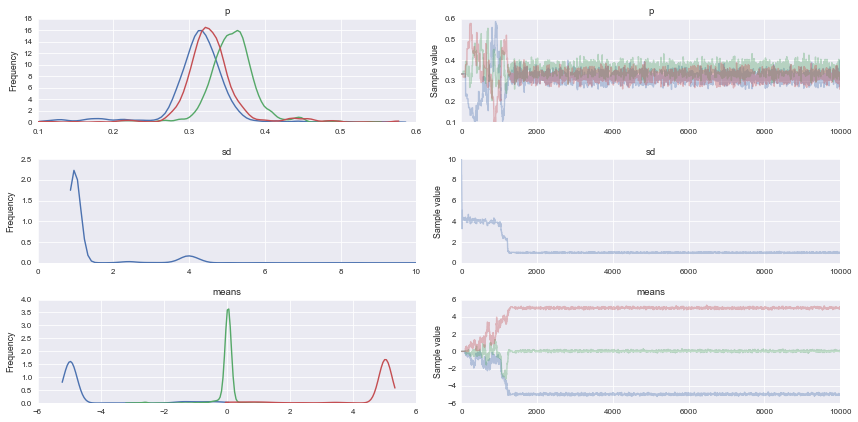

In [11]:
pm.plots.traceplot(tr, ['p', 'sd', 'means']);

## After convergence

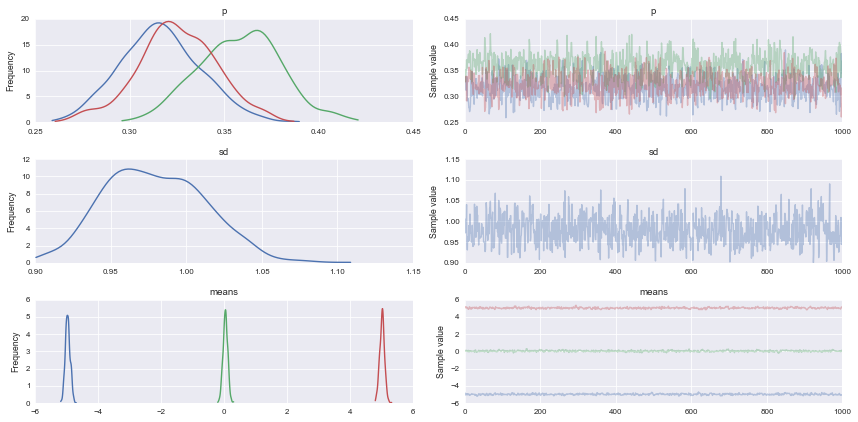

In [10]:
# take a look at traceplot for some model parameters
# (with some burn-in and thinning)
pm.plots.traceplot(tr[5000::5], ['p', 'sd', 'means']);

(<matplotlib.figure.Figure at 0x7fa3cc21ae80>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa3cc27a908>]], dtype=object))

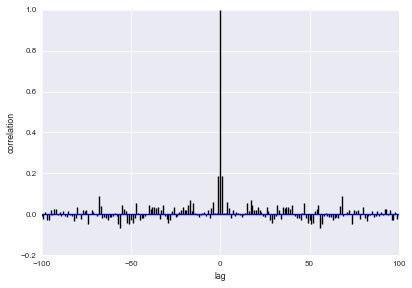

In [12]:
# I prefer autocorrelation plots for serious confirmation of MCMC convergence
pm.autocorrplot(tr[5000::5], varnames=['sd'])

## Sampling of cluster for individual data point

(0.0, 1000.0, -0.1, 2.1)

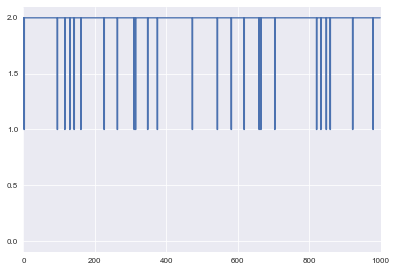

In [13]:
i=0
plt.plot(tr['category'][5000::5, i], drawstyle='steps-mid')
plt.axis(ymin=-.1, ymax=2.1)

true cluster: 2
  data value: 3.29


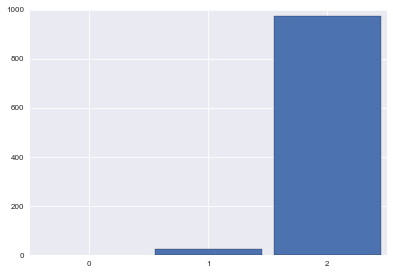

In [15]:
def cluster_posterior(i=0):
    print('true cluster:', v[i])
    print('  data value:', np.round(data[i],2))
    plt.hist(tr['category'][5000::5,i], bins=[-.5,.5,1.5,2.5,], rwidth=.9)
    plt.axis(xmin=-.5, xmax=2.5)
    plt.xticks([0,1,2])
cluster_posterior(i)